# In The Kitchen, Jets Twistin Like a Stir Fry

Does it help our network learn if we rotate our jets?

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import roc_curve

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
n_events = len(events)
print(n_events)

308955


Get jet locations, tag, truth

In [4]:
pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
E = events["resolved_lv"].E
tag = events["tag"] # tag[index] = [1, 1, 1, 0, 0, ...] (len >= 4)
truth = events["truth"]

Pad arrays

In [5]:
cutoff = 10
padding_val = 0

# cut off and pad
# cutoff+1 so we can have a no-4th-jet option as last index
padded_true = pad_sequences(truth,padding='post')[:,:cutoff+1]
padded_tag = pad_sequences(tag, padding='post')[:,:cutoff+1]
padded_pt = pad_sequences(pt, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_eta = pad_sequences(eta, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_phi = pad_sequences(phi, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_E = pad_sequences(E, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]

Filter a bit more for events where we have 3 b-jets correctly tagged (plus maybe one more untagged b-jet)

In [6]:
# 1 = should have been tagged but wasn't. 0 = correctly tagged (or not tagged)
untagged = np.logical_xor(padded_true, padded_tag).astype(int)

# n_untagged[i] = number of untagged real jets in i-th event
# We want to consider only the cases where the 3 jets are correctly tagged,
# so we have take n_untagged == 1
n_untagged = np.count_nonzero(untagged, axis=1)

# where there is no true 4th jet, say there's an untagged jet in the last index
untagged[(n_untagged == 0), -1] = 1

# for now, consider only the events where one jet is not tagged
untagged = untagged[n_untagged <= 1]
# or where there are only 3 real b jets
# u for untagged<=1
pt_u = padded_pt[n_untagged <= 1]
eta_u = padded_eta[n_untagged <= 1]
phi_u = padded_phi[n_untagged <= 1]
E_u = padded_E[n_untagged <= 1]

Rotation time!

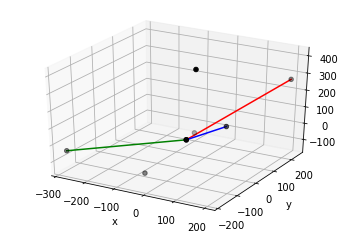

Sample original vector:
first jet: 198.26697 235.52194 271.26215
rotating about x by -0.8558051
new vector: 198.26697 359.2405 1.5258789e-05
rotating about z by -1.066491
new vector: 410.32123 0.0 1.5258789e-05
sign of x component 1.0
new vector: 410.32123 0.0 1.5258789e-05
new 2nd vector: -265.43628 173.86221 114.834854
rotating about x by -0.58371663
rotated vector should look like (x,y,0): -265.43628 208.36295 7.6293945e-06
first vector should be (x,0,0): 410.32123 8.409561e-06 1.273224e-05


In [7]:
# an event index for which to output some info
out_index = 20

# make vectors
vectors = urm.TLorentzVectorArray.from_ptetaphie(pt_u, eta_u, phi_u, E_u)

# plot an event's jets in x y z space
event_x = vectors.x[out_index]
event_y = vectors.y[out_index]
event_z = vectors.z[out_index]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot first couple jets
ax.plot([0, event_x[0]], [0, event_y[0]], [0, event_z[0]], c='red')
ax.plot([0, event_x[1]], [0, event_y[1]], [0, event_z[1]], c='green')
ax.plot([0, event_x[2]], [0, event_y[2]], [0, event_z[2]], c='blue')
# plot endpoints as dots
ax.scatter(event_x, event_y, event_z, c='black')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# x y z components of one vector
print("Sample original vector:")
print("first jet:", vectors.x[out_index][0], vectors.y[out_index][0], vectors.z[out_index][0])

# rotate about x so that z=0 for the first vector of each
theta_x = np.arctan2(vectors.z, vectors.y)[:,0]
print("rotating about x by", -theta_x[out_index])
theta_x = np.repeat(theta_x.reshape(-1, 1), cutoff+1, axis=1)
vectors_rx = vectors.rotatex(-theta_x)
print("new vector:", vectors_rx.x[out_index][0], vectors_rx.y[out_index][0], vectors_rx.z[out_index][0])

# then rotate about z so that y=0 (again for first vector only)
theta_z = np.arctan2(vectors_rx.y, vectors_rx.x)[:,0]
print("rotating about z by", -theta_z[out_index])
theta_z = np.repeat(theta_z.reshape(-1, 1), cutoff+1, axis=1)
vectors_rxry = vectors_rx.rotatez(-theta_z)
print("new vector:", vectors_rxry.x[out_index][0], vectors_rxry.y[out_index][0], vectors_rxry.z[out_index][0])

# flip all vectors to make all x components of first vectors positive
sign_x = np.sign(vectors_rxry.x)[:,0]
print("sign of x component", sign_x[out_index])
sign_x = np.repeat(sign_x.reshape(-1, 1), cutoff+1, axis=1)
vectors_flipped = vectors_rxry * (sign_x)
print("new vector:", vectors_flipped.x[out_index][0], vectors_flipped.y[out_index][0], vectors_flipped.z[out_index][0])

# now rotate about x again using 2nd vector so z=0 for the second vector
print("new 2nd vector:", vectors_flipped.x[out_index][1], vectors_flipped.y[out_index][1], vectors_flipped.z[out_index][1])
theta_x2 = np.arctan2(vectors_flipped.z, vectors_flipped.y)[:,1]
print("rotating about x by", -theta_x2[out_index])
theta_x2 = np.repeat(theta_x2.reshape(-1, 1), cutoff+1, axis=1)
vectors_final = vectors_flipped.rotatex(-theta_x2)
print("rotated vector should look like (x,y,0):", vectors_final.x[out_index][1], vectors_final.y[out_index][1], vectors_final.z[out_index][1])
print("first vector should be (x,0,0):", vectors_final.x[out_index][0], vectors_final.y[out_index][0], vectors_final.z[out_index][0])

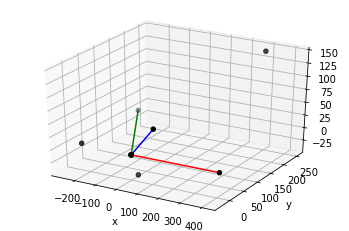

/home/callum/anaconda3/envs/437env/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


In [8]:
# plot an event's in x y z space after rotation
event_xf = vectors_final.x[out_index]
event_yf = vectors_final.y[out_index]
event_zf = vectors_final.z[out_index]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot first couple jets
ax.plot([0, event_xf[0]], [0, event_yf[0]], [0, event_zf[0]], c='red')
ax.plot([0, event_xf[1]], [0, event_yf[1]], [0, event_zf[1]], c='green')
ax.plot([0, event_xf[2]], [0, event_yf[2]], [0, event_zf[2]], c='blue')
# plot endpoints as dots
ax.scatter(event_xf, event_yf, event_zf, c='black')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# get pt, eta, phi again, replacing any NaN values with 0 again
pt = vectors_final.pt
eta = np.nan_to_num(vectors_final.eta, nan=0)
phi = vectors_final.phi

In [9]:
# snip off the 3 first jets since they're already tagged correctly
# (given our filtering procedure above)
untagged = untagged[:, 3:]
pt = pt[:, 3:]
eta = eta[:, 3:]
phi = phi[:, 3:]

# where does the untagged jet occur?
# 7 = no 4th jet, 0-6 means set that index's jet = 4th
missed_jet_index = np.where(untagged==1)[1]

In [10]:
# scale data to be keras-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)

# stack pt, eta, phi for input into model
s_in = np.column_stack((s_pt, s_eta, s_phi))

Split data into training, validation, and testing subsets

In [11]:
# split missed_jet into training, validation, testing subsets
train, val, test = tools.splitTVT(untagged, trainfrac=0.7, testfrac=0.2)

To do: experiment with different kinds of networks

In [12]:
model = Sequential()
model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='normal', activation='softmax'))
# compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [13]:
import time
before = time.time()
history = model.fit(s_in[train], untagged[train], validation_data=(s_in[val], untagged[val]), epochs = 200, batch_size = 200, verbose = 1)

timedelta = time.time() - before
print(timedelta)


Train on 212748 samples, validate on 30393 samples
Epoch 1/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.8297 - acc: 0.4013 - val_loss: 1.3830 - val_acc: 0.4464
Epoch 2/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.2767 - acc: 0.4429 - val_loss: 1.2366 - val_acc: 0.4420
Epoch 3/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.2229 - acc: 0.4494 - val_loss: 1.2125 - val_acc: 0.4504
Epoch 4/200
212748/212748 [==============================] - 1s 5us/step - loss: 1.2053 - acc: 0.4564 - val_loss: 1.1998 - val_acc: 0.4575
Epoch 5/200
212748/212748 [==============================] - 1s 5us/step - loss: 1.1948 - acc: 0.4593 - val_loss: 1.1910 - val_acc: 0.4582
Epoch 6/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.1875 - acc: 0.4616 - val_loss: 1.1846 - val_acc: 0.4596
Epoch 7/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.1818 - acc: 0.4623 - val_loss: 1

212748/212748 [==============================] - 1s 6us/step - loss: 1.0981 - acc: 0.4924 - val_loss: 1.0987 - val_acc: 0.4907
Epoch 60/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0976 - acc: 0.4930 - val_loss: 1.0978 - val_acc: 0.4894
Epoch 61/200
212748/212748 [==============================] - 1s 5us/step - loss: 1.0970 - acc: 0.4925 - val_loss: 1.0972 - val_acc: 0.4905
Epoch 62/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0964 - acc: 0.4931 - val_loss: 1.0970 - val_acc: 0.4883
Epoch 63/200
212748/212748 [==============================] - 1s 5us/step - loss: 1.0959 - acc: 0.4934 - val_loss: 1.0962 - val_acc: 0.4905
Epoch 64/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0953 - acc: 0.4933 - val_loss: 1.0956 - val_acc: 0.4909
Epoch 65/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0948 - acc: 0.4929 - val_loss: 1.0952 - val_acc: 0.4896
Epoch 66/200
212748/212748 [=====

212748/212748 [==============================] - 1s 7us/step - loss: 1.0775 - acc: 0.4964 - val_loss: 1.0798 - val_acc: 0.4951
Epoch 118/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.0773 - acc: 0.4963 - val_loss: 1.0797 - val_acc: 0.4942
Epoch 119/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0771 - acc: 0.4966 - val_loss: 1.0798 - val_acc: 0.4936
Epoch 120/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0769 - acc: 0.4965 - val_loss: 1.0792 - val_acc: 0.4947
Epoch 121/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0767 - acc: 0.4968 - val_loss: 1.0792 - val_acc: 0.4955
Epoch 122/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0765 - acc: 0.4967 - val_loss: 1.0790 - val_acc: 0.4949
Epoch 123/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0763 - acc: 0.4967 - val_loss: 1.0788 - val_acc: 0.4949
Epoch 124/200
212748/212748

212748/212748 [==============================] - 1s 6us/step - loss: 1.0691 - acc: 0.4986 - val_loss: 1.0724 - val_acc: 0.4979
Epoch 176/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0690 - acc: 0.4991 - val_loss: 1.0722 - val_acc: 0.4985
Epoch 177/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0689 - acc: 0.4993 - val_loss: 1.0721 - val_acc: 0.4983
Epoch 178/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.0688 - acc: 0.4994 - val_loss: 1.0720 - val_acc: 0.4968
Epoch 179/200
212748/212748 [==============================] - 1s 6us/step - loss: 1.0687 - acc: 0.4992 - val_loss: 1.0720 - val_acc: 0.4982
Epoch 180/200
212748/212748 [==============================] - 2s 9us/step - loss: 1.0687 - acc: 0.4994 - val_loss: 1.0719 - val_acc: 0.4969
Epoch 181/200
212748/212748 [==============================] - 1s 7us/step - loss: 1.0686 - acc: 0.4996 - val_loss: 1.0718 - val_acc: 0.4983
Epoch 182/200
212748/212748

<Figure size 432x288 with 0 Axes>

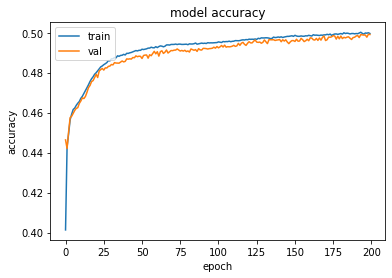

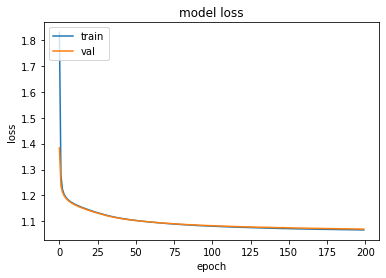

In [14]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
plt.show()

In [15]:
nn_score = model.predict(s_in)

In [16]:
test_nn_score = nn_score[test]

# sort nn_score highest to lowest
indices = test_nn_score.argsort()

# prepare for roc curve plot
best_index_asc = test_nn_score.argsort(axis=1)
best_index = best_index_asc[:,::-1]
test_mj = untagged[test]
s_test_mj = test_mj[np.arange(test_mj.shape[0])[:,None], best_index]
s_test_score = test_nn_score[np.arange(test_nn_score.shape[0])[:,None], best_index]
max_true = to_categorical(s_test_mj[:,0], num_classes = 2)
max_true = s_test_mj[:,0]
max_val = s_test_score[:,0]
fpr, tpr, thresholds = roc_curve(max_true, max_val, pos_label=1)

<Figure size 432x288 with 0 Axes>

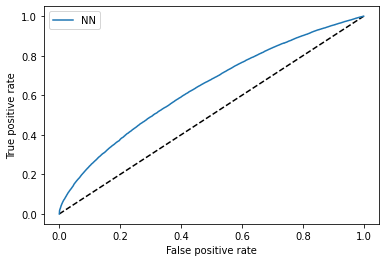

In [17]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()

A sample event

In [18]:
n_test = len(test) 

# get truth and tag arrays back
test_truth = np.array([[1, 1, 1] + list(t) for t in untagged[test]])
# all the tags were just 111000000 by construction
test_tag = np.array([[1, 1, 1] + [0]*len(t) for t in untagged[test]])

# selection_index[i] is between 0 and 7
# these correspond to picking jet 4 --> 10 or no jet ("jet 11")
selection_index = np.argmax(nn_score[test], axis=1)

# put this in a better format
selection_index += 3
selections = np.zeros_like(test_tag, dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1

# then chop off the last index so selection = [0,...,0] for no selection
test_truth = test_truth[:, :-1]
test_tag = test_tag[:, :-1]
selections = selections[:, :-1]

100%|██████████| 60785/60785 [00:00<00:00, 130042.36it/s]


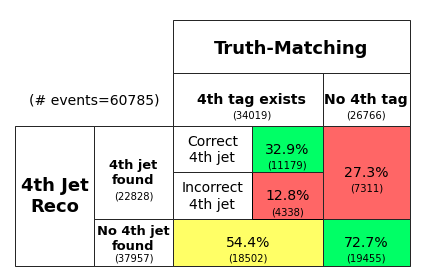

(32.86104823774949,
 12.75169758076369,
 54.38725418148681,
 27.314503474557277,
 72.68549652544273)

In [19]:
tools.evaluate_model(test_truth, test_tag, selections, savename="simple_rotation")